# Hello, and welcome to my Indeed Data Analysis Notebook!

This project is partially inspired by my brother. He's been living in Florida for the past two years now, because he was able to find a great job down there after grad school. But recently, he and I have been talking about how he would like to get a new job closer to home. His job would like him to stay in Florida to work on site, so he's been looking for both jobs in the NYC area, and jobs that he can do remotely which would allow him to live in NYC, even if his employer is somewhere else. This got me thinking: what does the remote work job market look like? Are there enough employers looking for people to work from home? Are there enough options out there for people who don't want to sacrifice things like cost of living and proximity to family in order to keep a good career? 

I decided to answer this by sampling data from Indeed.com, one of the top job boards in the United States. I used scrapy to pull all jobs listed as "remote" by employers that were posted most recently - so all of my entries have been posted between 5/7/2020 and 5/9/2020. From all job postings, I was able to pull the company name, the job summary, job title, job type (Full Time, Part Time, Contract, etc.), location (of the company that was posting), number of ratings and ratings out of 5 stars (for companies that had ratings data), and salary. 

With this data, I hope to answer a few important questions: 

- What companies are posting these types of jobs? 
- What kinds of jobs are they? Are they mostly full time, or part time? Salary, or commission? 
- Are these kinds of jobs mostly entry level, or a mix of different seniority levels?
- What kind of education do you need for these jobs? 
- Do these kinds of jobs pay well, when compared to nationwide and statewide median salary levels? 
- Do you need to live close to the company, or is this a true remote opportunity where you can live anywhere in the US?

I also want to see how many jobs are only being posted as remote jobs due to Covid 19 - we'll get back to that later. 

First thing's first, I'm going to install all my packages, and download my data set!

In [106]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
plt.style.use('ggplot')


indeed_remote_usa = "indeed_remote_usa.csv"

indeed_data = pd.read_csv(indeed_remote_usa)

indeed_data.head()

,company_name,day_posted,job_bullets_text,job_headings_text,job_summary,job_title,job_type,location,num_ratings,rating_out_of_5,remote,salary
0,Operations Consultants of Colorado Springs,Just posted,"Open additional practices/locations,Optimize c...",We are highly adaptable and aiming to build a ...,ThriveStar Consulting is an up and coming cons...,Agile (Scrum) Consultant for Health Care Pract...,"- Part-time, Contract, Commission","Colorado Springs, CO",0,NaN,NaN,$20 - $40 an hour
1,Elevate AG,Today,"One location,None,Innovative -- innovative and...",NaN,Looking for a guitar player who can also help ...,Acoustic Guitarist/ Singer,- Part-time,"Frankfort, KY 40601",0,NaN,NaN,$10 - $20 an hour
2,Intersect Services LLC,Today,working with individuals with intellectual dis...,NaN,Support Coordinators assist individuals with d...,Waiver Support Coordinator,NaN,"Clearfield, UT 84015",0,NaN,NaN,$16 - $18 an hour
3,"Global Resource Operations, LLC",Today,"Holistic Centers,Chiropractors,Massage Studios...","Company Summary: ,Product overview: ,Job Summa...","Company Summary: ,Here at Vana Labs, our team ...","National, regional and local sales distributio...",NaN,"Miami, FL",0,NaN,NaN,"$1,425 - $2,000 a day"
4,"Legal Technologies, LLC",Today,"United States (Required),One location,Paid tim...",NaN,Our law firm is looking for interns to assist ...,Legal Intern (SUMMER and FALL),"- Full-time, Part-time, Internship","Austin, TX 78704",0,NaN,NaN,$7.50 an hour


The "remote" column was intended to show whether a job was remote or not, but I had some trouble with importing and if my filter is for remote jobs anyway, it's redundant. So I'm going to drop this column. 

In [107]:
indeed_data = indeed_data.drop(['remote'], axis = 1)
indeed_data.head()

,company_name,day_posted,job_bullets_text,job_headings_text,job_summary,job_title,job_type,location,num_ratings,rating_out_of_5,salary
0,Operations Consultants of Colorado Springs,Just posted,"Open additional practices/locations,Optimize c...",We are highly adaptable and aiming to build a ...,ThriveStar Consulting is an up and coming cons...,Agile (Scrum) Consultant for Health Care Pract...,"- Part-time, Contract, Commission","Colorado Springs, CO",0,NaN,$20 - $40 an hour
1,Elevate AG,Today,"One location,None,Innovative -- innovative and...",NaN,Looking for a guitar player who can also help ...,Acoustic Guitarist/ Singer,- Part-time,"Frankfort, KY 40601",0,NaN,$10 - $20 an hour
2,Intersect Services LLC,Today,working with individuals with intellectual dis...,NaN,Support Coordinators assist individuals with d...,Waiver Support Coordinator,NaN,"Clearfield, UT 84015",0,NaN,$16 - $18 an hour
3,"Global Resource Operations, LLC",Today,"Holistic Centers,Chiropractors,Massage Studios...","Company Summary: ,Product overview: ,Job Summa...","Company Summary: ,Here at Vana Labs, our team ...","National, regional and local sales distributio...",NaN,"Miami, FL",0,NaN,"$1,425 - $2,000 a day"
4,"Legal Technologies, LLC",Today,"United States (Required),One location,Paid tim...",NaN,Our law firm is looking for interns to assist ...,Legal Intern (SUMMER and FALL),"- Full-time, Part-time, Internship","Austin, TX 78704",0,NaN,$7.50 an hour


Now I'll gather some summary statistics about ratings, for companies that have them. 

In [144]:
indeed_data['num_ratings'] = indeed_data['num_ratings'].replace(0, None)
avg_ratings = round(indeed_data['num_ratings'].mean())
avg_stars = round(indeed_data['rating_out_of_5'].mean(skipna = True), 1)
median_stars = round(indeed_data['rating_out_of_5'].median(skipna = True), 1)
sd_stars = round(indeed_data['rating_out_of_5'].std(skipna = True), 1)
print("Average Ratings: " + str(avg_ratings))
print("Average Stars: " + str(avg_stars))
print("Median Stars: " + str(median_stars))
print("St Dev Stars: " + str(sd_stars))

Average Ratings: 2089
Average Stars: 3.6
Median Stars: 3.6
St Dev Stars: 0.7


I don't imagine I'll do too much with the average ratings, but with the average stars, I can probably see if companies that frequently post remote jobs are well above or well below the average rating. 

Speaking of companies, I'd like to view a couple of things right now: 

- How many different companies are in this sample data set? 
- Do companies post more than one job? If so, how many jobs do the top companies post? What companies are they?

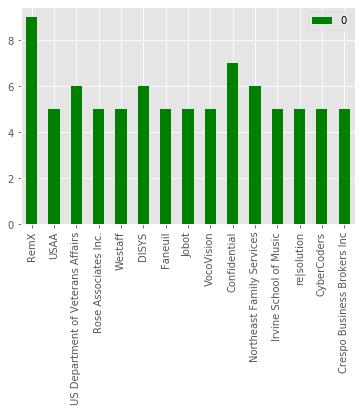

In [131]:
all_companies = list(indeed_data['company_name'])
#print(all_companies)

company_list = {}
for company in all_companies:
    company_list[company] = all_companies.count(company)
    
frequent_companies = list(filter(lambda x: company_list[x] > 4, company_list))

top_15 = [company_list[frequent_company] for frequent_company in frequent_companies]

top_15_dict = dict(zip(frequent_companies, top_15))

the_most = pd.DataFrame.from_dict(top_15_dict, orient = 'index')

the_most.plot.bar(color = 'g')

847
1051


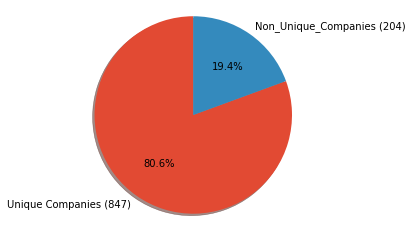

In [141]:
companies = indeed_data['company_name'].unique()
num_companies = len(companies)
print(num_companies)

total_posts = len(indeed_data['company_name'])
print(total_posts)

labels = 'Unique Companies (847)', 'Non_Unique_Companies (204)'
sizes = [num_companies, (total_posts - num_companies)]
explode = (0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

735


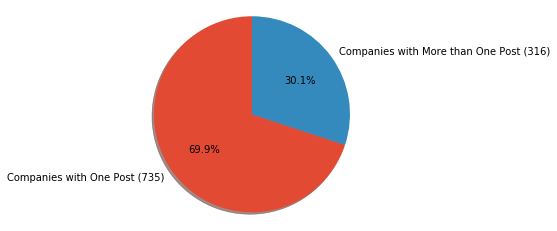

In [143]:
one_timers = list(filter(lambda x: company_list[x] == 1, company_list))
num_one_timers = (len(one_timers))
print(num_one_timers)

labels = 'Companies with One Post (735)', 'Companies with More than One Post (316)'
sizes = [num_one_timers, (total_posts - num_one_timers)]
explode = (0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

23


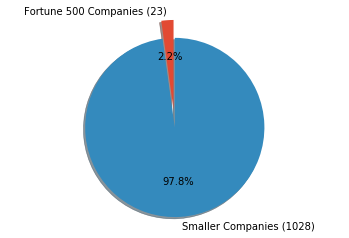

In [156]:
fortune_500 = pd.read_csv('Fortune_500_List.csv')
fortune_500.head()

fortune_list = list(fortune_500['Company Name'])

fortune_posters = [company for company in all_companies if company in fortune_list]
num_fortune_posters = len(fortune_posters)
print(num_fortune_posters)

labels = 'Fortune 500 Companies (23)', 'Smaller Companies (1028)'
sizes = [num_fortune_posters, (total_posts - num_fortune_posters)]
explode = (0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

It looks like we can conclude the following: 

- Over the course of roughly two days, 30% of companies are so in need of remote workers that they will post multiple job ads
- But given the short time frame, it looks like the postings are mostly unique
- Smaller companies seem to be looking more heavily. Fortune 500 companies are barely posting, and the top 15 posters are either small businesses or government organizations. 

Now what does the spread look like for location? 

22
{'Miami, FL': 9, 'Austin, TX': 16, 'New York, NY': 31, 'Philadelphia, PA': 12, 'San Diego, CA': 10, 'Tampa, FL': 10, 'San Jose, CA': 9, 'Nashville, TN': 8, 'Cleveland, OH': 8, 'Washington, DC': 26, 'Seattle, WA': 11, 'Los Angeles, CA': 18, 'Dallas, TX': 9, 'Chicago, IL': 31, 'Phoenix, AZ': 10, 'Boston, MA': 12, 'Houston, TX': 9, 'Atlanta, GA': 13, 'Irvine, CA': 9, 'Portland, OR': 12}
273


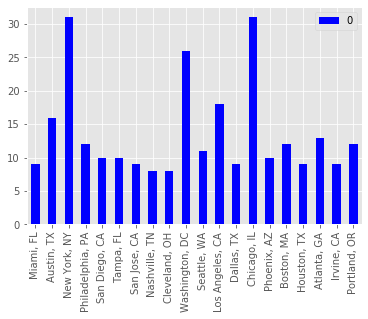

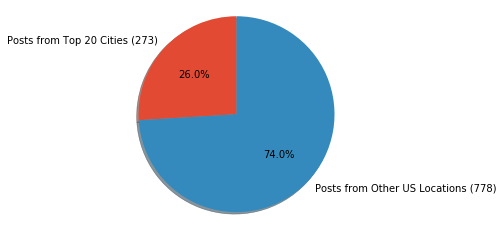

In [416]:
all_locations = list(indeed_data['location'])
all_locations = [re.sub('\d+', '', location) for location in all_locations]
all_locations = [location.strip() for location in all_locations]

location_list = {}
for location in all_locations:
    location_list[location] = all_locations.count(location)
    
    
frequent_locations = list(filter(lambda x: location_list[x] > 7, location_list))
print(len(frequent_locations))

top_20_loc = [location_list[frequent_location] for frequent_location in frequent_locations]

top_20_loc_dict = dict(zip(frequent_locations, top_20_loc))

del top_20_loc_dict["United States"]
del top_20_loc_dict["Remote"]
print(top_20_loc_dict)

the_most_loc = pd.DataFrame.from_dict(top_20_loc_dict, orient = 'index')

the_most_loc.plot.bar(color = 'b')

top_20_num = sum(top_20_loc_dict.values())
print(top_20_num)

labels = 'Posts from Top 20 Cities (273)', 'Posts from Other US Locations (778)'
sizes = [top_20_num, (total_posts - top_20_num)]
explode = (0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

So it looks like over a quarter of our posts that are looking for remote jobs are based in 20 major cities around the United States. 

Depending on how you look at it, this is a very good thing! Jobs in cities tend to have higher salaries than jobs outside of cities due to the higher cost of living, so if a remote offer is taken from a city-based job, you could potentially get more bang for your buck due to cost of living adjustments. 

Speaking of salaries, let's take a look at what these remote jobs pay. 

company_name           0
day_posted             0
job_bullets_text       0
job_headings_text      0
job_summary            0
job_title              0
job_type             635
location               0
num_ratings            0
rating_out_of_5      546
salary               425
dtype: int64
hour     328
year     264
month     16
week      10
++         5
day        3
Name: pay_schedule, dtype: int64


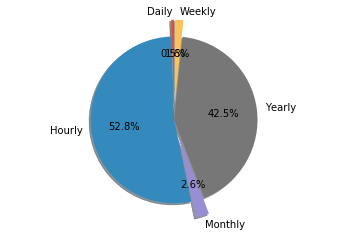

In [336]:
print(np.sum(indeed_data.isnull()))

all_salaries = list(indeed_data['salary'])
all_salaries = [str(salary).split(" ") for salary in all_salaries]
#print(all_salaries)
min_pay = list(map(lambda x: x[0], all_salaries))
max_pay = list(map(lambda x: x[2] if len(x) > 3 else x[0], all_salaries))
pay_time = list(map(lambda x: x[-1], all_salaries))

min_pay = [float(pay.replace("$", '').replace(',', '').replace("Up", '0').replace('From', '0')) for pay in min_pay]
max_pay = [float(pay.replace("$", '').replace(',', '').replace('hour', '0').replace('an', '0').replace('n0', "0")) for pay in max_pay]


salary_data = {"minimum": min_pay, 
              "maximum": max_pay, 
              "pay_schedule": pay_time}

salary_df = pd.DataFrame(salary_data)
salary_df

salary_df = salary_df.dropna(axis = 0, how = "any")
salary_df

print(salary_df['pay_schedule'].value_counts())

labels = "Daily", "Hourly", "Monthly", "Yearly", "Weekly"
sizes = [3, 328, 16, 264, 10]
explode = (0.2, 0, 0.2, 0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [337]:
salary_df

salary_df.loc[salary_df.pay_schedule == 'hour', "minimum"] = salary_df["minimum"] * 2080
salary_df.loc[salary_df.pay_schedule == 'hour', "maximum"] = salary_df["maximum"] * 2080
salary_df.loc[salary_df.pay_schedule == 'day', "minimum"] = salary_df["minimum"] * 365
salary_df.loc[salary_df.pay_schedule == 'day', "maximum"] = salary_df["maximum"] * 365
salary_df.loc[salary_df.pay_schedule == 'week', "minimum"] = salary_df["minimum"] * 52
salary_df.loc[salary_df.pay_schedule == 'week', "maximum"] = salary_df["maximum"] * 52
salary_df.loc[salary_df.pay_schedule == 'month', "minimum"] = salary_df["minimum"] * 12
salary_df.loc[salary_df.pay_schedule == 'month', "maximum"] = salary_df["maximum"] * 12
salary_df.loc[salary_df.pay_schedule != "++"]

#RUN THIS CELL ONLY ONCE

,minimum,maximum,pay_schedule
0,41600.0,83200.0,hour
1,20800.0,41600.0,hour
2,33280.0,37440.0,hour
3,520125.0,730000.0,day
4,15600.0,15600.0,hour
...,...,...,...
1040,50000.0,100000.0,year
1041,50000.0,55000.0,year
1043,90000.0,100000.0,year
1048,55000.0,75000.0,year


In [338]:
print(salary_df.describe())
salary_sds = list(salary_df.std())
salary_df = salary_df.loc[salary_df.minimum <= (salary_sds[0]*3)]
salary_df = salary_df.loc[salary_df.maximum <= (salary_sds[1]*3)]

#RUN THIS CELL ONLY ONCE

             minimum        maximum
count     626.000000     626.000000
mean    49994.334345   66001.174441
std     34793.780164   49136.656076
min         0.000000       0.000000
25%     31200.000000   37440.000000
50%     40000.000000   52000.000000
75%     60000.000000   80000.000000
max    520125.000000  730000.000000


             minimum        maximum
count     576.000000     576.000000
mean    44008.000521   56203.835417
std     20247.143528   26828.089363
min         0.000000       0.000000
25%     31200.000000   37440.000000
50%     38507.000000   50000.000000
75%     52012.000000   70000.000000
max    104000.000000  145320.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B98E1D108>,
      dtype=object)

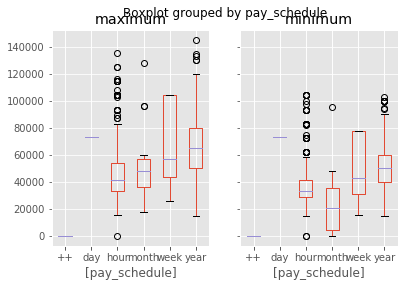

In [339]:
print(salary_df.describe())

salary_df.boxplot(by ="pay_schedule")

Looks like the salaried positions (yearly) pay higher on average than the other types of positions - even though the range isn't as wide. Once outliers are taken out of the equation, the interquartile range for all salaries isn't very high at all. But a median minimum of 38,500 and a median maximum of 50,000 is livable depending on where you live. Plus, the range for the hourly jobs indicates that there are many outliers - meaning that the right type of skills could land you a very well paying hourly gig. 

Now for job type = are most of these jobs full time? Part time? Contract? 

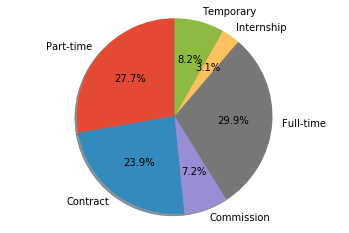

In [376]:
#print(indeed_data['job_type'].value_counts())

all_job_types = list(indeed_data['job_type'])

all_job_types = [str(job).replace('\xa0-\xa0\xa0', '').split(',') for job in all_job_types]

def chain_list(nested_list):
    chain = []
    for lst in nested_list:
        for i in lst:
            chain.append(i)
    return chain

all_job_types = chain_list(all_job_types)

job_type_dict = {}
for job_type in all_job_types:
    job_type_dict[job_type] = all_job_types.count(job_type)
del job_type_dict['nan']
del job_type_dict['Other']

job_type_dict_clean = {'Part-time': 95+112,
                      'Contract': 93 + 85,
                      'Commission': 35 + 19, 
                      "Full-time": 182 + 41, 
                      "Internship": 10 + 13, 
                      "Temporary": 41 + 20}



labels = job_type_dict_clean.keys()
sizes = job_type_dict_clean.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

There's actually a healthy mix of all job types - although some jobs have been listed under multiple types. This means that no matter the kind of work that you're looking for, you can find it! Maybe you want a full time job, or maybe you just want something short term or temporary. 

Finally, we're going to take a look at a few word clouds that will be used to parse through the job summaries, and determine what education levels and experience levels are needed for these types of jobs. From the general word cloud, we may find some interesting trends as well! 

In [411]:
indeed_data['job_bullets_text'] = indeed_data['job_bullets_text'].fillna('')
indeed_data['job_headings_text'] = indeed_data['job_headings_text'].fillna('')
rem_del = ['[removed]', '[deleted]']
indeed_data['job_bullets_text'] = indeed_data['job_bullets_text'].apply(lambda x: '' if x in rem_del else x)
indeed_data['job_headings_text'] = indeed_data['job_headings_text'].apply(lambda x: '' if x in rem_del else x)

from nltk.corpus import stopwords
stop = stopwords.words('english')

indeed_data['job_summary'] = indeed_data['job_summary'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))
indeed_data['job_bullets_text'] = indeed_data['job_bullets_text'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))
indeed_data['job_headings_text'] = indeed_data['job_headings_text'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))

all_text = all_job_types = list(indeed_data['job_summary']) + list(indeed_data['job_bullets_text']) + list(indeed_data['job_headings_text'])

summary_text = list(indeed_data['job_summary'])
bullets_text = list(indeed_data['job_bullets_text'])
headings_text = list(indeed_data['job_headings_text'])

big_text = ' '.join(all_text).lower()

big_summary_text = ' '.join(summary_text).lower()

big_bullets_text = ' '.join(bullets_text).lower()

big_headings_text = ' '.join(headings_text).lower()


In [415]:
# big_text_dict = {}
# for text in big_text:
#     big_text_dict[text] = big_text.count(text)

# frequent_text = list(filter(lambda x: big_text_dict[x] > 10000, big_text_dict))
# print(frequent_text)

big_summary_text_dict = {}
for text in big_summary_text:
    big_summary_text_dict[text] = big_summary_text.count(text)

frequent_summary_text = list(filter(lambda x: big_summary_text_dict[x] > 10000, big_summary_text_dict))
print(frequent__summary_text)

KeyboardInterrupt: 

In [412]:
big_text = TextBlob(big_text).words
big_summary_text = TextBlob(big_summary_text).words
big_bullets_text = TextBlob(big_bullets_text).words
big_headings_text = TextBlob(big_headings_text).words

stemmer = PorterStemmer()
stemmed_big_text = ' '.join([stemmer.stem(word) for word in big_text])
stemmed_big_summary_text = ' '.join([stemmer.stem(word) for word in big_summary_text])
stemmed_big_bullets_text = ' '.join([stemmer.stem(word) for word in big_bullets_text])
stemmed_big_headings_text = ' '.join([stemmer.stem(word) for word in big_headings_text])

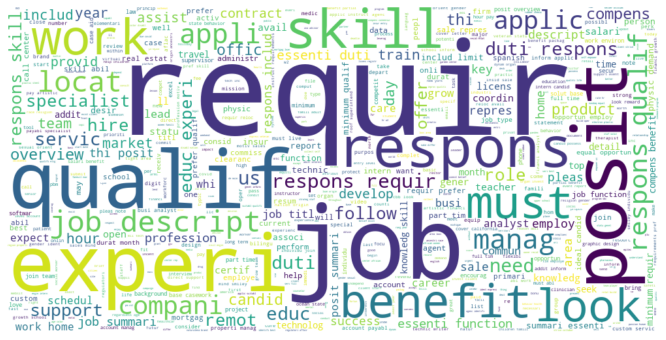

In [413]:
words = WordCloud(background_color="white", max_words=1000, width=1000, height=500)
words.generate(stemmed_big_headings_text)
plt.figure(figsize=(12, 6))
plt.imshow(words, interpolation='bilinear')
plt.axis("off")
plt.show()

Unfortunately I'm having trouble getting my word cloud to work properly. I don't know how to filter out the right combination of words at this point. So I'll have to defer this specific part of my analysis until a later time. 

I hope this work has been insightful to you, and I'll update this document periodically as I continue to add to my dataset and skillset. Thank you for reading!